In [1]:
import torch 
import pandas as pd
import numpy as np
import torch.nn as nn 
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
with open(r"C:\Users\weitao\Desktop\Untitled Folder\ml\train-images-idx3-ubyte\train-images.idx3-ubyte", encoding="gbk") as f:
    # 只能读取固定格式的二进制文件
    loaded = np.fromfile(file=f, dtype=np.uint8)
    train_data = loaded[16:].reshape((60000, 784))
print("训练样本数据维度: ", train_data.shape)
with open(r"C:\Users\weitao\Desktop\Untitled Folder\ml\train-labels-idx1-ubyte\train-labels.idx1-ubyte", encoding="gbk") as f:
    # 只能读取固定格式的二进制文件
    loaded = np.fromfile(file=f, dtype=np.uint8)
    train_label = loaded[8:].reshape((60000, 1))
print("训练样本标签维度: ", train_label.shape)

训练样本数据维度:  (60000, 784)
训练样本标签维度:  (60000, 1)


标签:  [5]


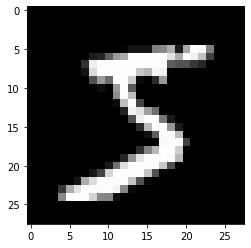

In [5]:
sample = train_data[0, :].reshape(28, 28)
label = train_label[0, :]
print("标签: ", label)
plt.imshow(sample, cmap="gray")

In [9]:
class MyDataset(Dataset):
    def __init__(self, image_file_name, label_file_name):
        self.image_file_name = image_file_name
        self.label_file_name = label_file_name
        with open(self.image_file_name, encoding="gbk") as f:
            loaded = np.fromfile(file=f, dtype=np.uint8)
            self.train_data = loaded[16:].reshape((60000, 784))
        with open(self.label_file_name, encoding="gbk") as f:
            loaded = np.fromfile(file=f, dtype=np.uint8)
            self.train_label = loaded[8:].reshape((60000, 1))
        self.train_data = torch.from_numpy(self.train_data.reshape(-1, 1, 28, 28)).float() / 255.0
        self.train_label = torch.from_numpy(self.train_label).reshape(60000)
        self.train_label = self.train_label.long()
        

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        sample = {"data": self.train_data[index], "label": self.train_label[index]}
        return sample

    def __len__(self):
        return len(self.train_data)

torch.Size([28, 28])
标签:  5


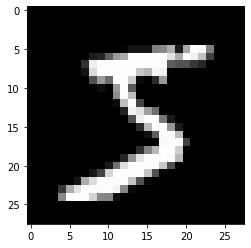

In [10]:
dataset = MyDataset(r"C:\Users\weitao\Desktop\Untitled Folder\ml\train-images-idx3-ubyte\train-images.idx3-ubyte", r"C:\Users\weitao\Desktop\Untitled Folder\ml\train-labels-idx1-ubyte\train-labels.idx1-ubyte")
sample = dataset.train_data[0].reshape(28, 28)
# sample = dataset.train_data[0]
print(sample.shape)
label = dataset.train_label[0]
print("标签: ", label.item())
plt.imshow(sample, cmap="gray")

In [11]:
dataset_length = len(dataset)
trainset_length = int(0.7 * dataset_length)
validset_length = int(0.1 * dataset_length)
testset_length = dataset_length - trainset_length - validset_length
# random_split已经对数据进行随机选取，随机数和随机种子有关。如果不用random_split，一定要先数据集打乱(np.random.shuffle(index_list))再取。
trainset, validset, testset = random_split(dataset, [trainset_length, validset_length, testset_length])
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
validloader = DataLoader(validset, batch_size=100, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

In [28]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(6, 16, 5), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2), 
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 120), 
            nn.BatchNorm1d(120), 
            nn.ReLU(), 
            nn.Linear(120, 84), 
            nn.BatchNorm1d(84), 
            nn.ReLU(), 
            nn.Linear(84, 10)
        )
    
    def forward(self, x):
        conv_res = self.conv(x)
        return self.fc(conv_res.view(x.shape[0], -1))

In [29]:
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
# 一次epoch代表将整个训练集跑了一次
for epoch in range(10):
    runing_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data["data"], data["label"]
        optimizer.zero_grad()
        # print(inputs.shape)
        pred = model(inputs)
        # print(pred)
        # break
        # 如果有多个样本，则已经做了平均
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        runing_loss += loss.item()
    print("loss: %.3f"%(runing_loss / (i+1)))
    # 验证集上看本次模型的效果
    with torch.no_grad():
        correct = 0
        total = 0
        for i, data in enumerate(validloader, 0):
            inputs, labels = data["data"], data["label"]
            out = model(inputs)
            _, pre = torch.max(out.data, 1)
            total += labels.size(0)
            correct += (labels == pre).sum().item()
        # print(correct, total)
        print("accuary: %.3f" %(correct / total))

loss: 0.126
accuary: 0.976
loss: 0.058
accuary: 0.978
loss: 0.047
accuary: 0.981
loss: 0.036
accuary: 0.983
loss: 0.034
accuary: 0.985
loss: 0.028
accuary: 0.986
loss: 0.026
accuary: 0.983
loss: 0.022
accuary: 0.986
loss: 0.023
accuary: 0.983
loss: 0.018
accuary: 0.985


In [30]:
with torch.no_grad():
    correct = 0
    total = 0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data["data"], data["label"]
        out = model(inputs)
        _, pre = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (labels == pre).sum().item()
    print(correct, total)
    print("accuary: %.3f" %(correct / total))

11845 12000
accuary: 0.987
